In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import itemfreq
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from normalization import normalize_corpus

# Term similarity

In [3]:
root = 'Believe'
term1 = 'beleive'
term2 = 'bargain'
term3 = 'Elephant'

In [4]:
def cosine_distance(u, v):
    distance = 1.0 - (np.dot(u, v) / 
                        (np.sqrt(sum(np.square(u))) * np.sqrt(sum(np.square(v))))
                     )
    return distance

In [12]:
word_list = [word.lower() for word in terms]
word_list

['believe', 'beleive', 'bargain', 'elephant']

In [14]:
[list(word) for word in word_list]

[['b', 'e', 'l', 'i', 'e', 'v', 'e'],
 ['b', 'e', 'l', 'e', 'i', 'v', 'e'],
 ['b', 'a', 'r', 'g', 'a', 'i', 'n'],
 ['e', 'l', 'e', 'p', 'h', 'a', 'n', 't']]

In [15]:
np.hstack([list(word) for word in word_list])

array(['b', 'e', 'l', 'i', 'e', 'v', 'e', 'b', 'e', 'l', 'e', 'i', 'v',
       'e', 'b', 'a', 'r', 'g', 'a', 'i', 'n', 'e', 'l', 'e', 'p', 'h',
       'a', 'n', 't'], 
      dtype='<U1')

In [16]:
unique_chars = np.unique(np.hstack([list(word) for word in word_list]))
unique_chars

array(['a', 'b', 'e', 'g', 'h', 'i', 'l', 'n', 'p', 'r', 't', 'v'], 
      dtype='<U1')

In [18]:
word_list_term_counts = [{char: count for char, count in itemfreq(list(word))} for word in word_list]
word_list_term_counts

[{'b': '1', 'e': '3', 'i': '1', 'l': '1', 'v': '1'},
 {'b': '1', 'e': '3', 'i': '1', 'l': '1', 'v': '1'},
 {'a': '2', 'b': '1', 'g': '1', 'i': '1', 'n': '1', 'r': '1'},
 {'a': '1', 'e': '2', 'h': '1', 'l': '1', 'n': '1', 'p': '1', 't': '1'}]

In [19]:
boc_vectors = [np.array([int(word_term_counts.get(char, 0)) for char in unique_chars])
                   for word_term_counts in word_list_term_counts]
boc_vectors

[array([0, 1, 3, 0, 0, 1, 1, 0, 0, 0, 0, 1]),
 array([0, 1, 3, 0, 0, 1, 1, 0, 0, 0, 0, 1]),
 array([2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]),
 array([1, 0, 2, 0, 1, 0, 1, 1, 1, 0, 1, 0])]

In [20]:
def boc_term_vectors(word_list):
    word_list = [word.lower() for word in word_list]
    unique_chars = np.unique(np.hstack([list(word) for word in word_list]))
    word_list_term_counts = [{char: count for char, count in itemfreq(list(word))} for word in word_list]
    boc_vectors = [np.array([int(word_term_counts.get(char, 0)) for char in unique_chars])
                   for word_term_counts in word_list_term_counts]
    return list(unique_chars), boc_vectors

In [21]:
terms = [root, term1, term2, term3]

In [22]:
features, (boc_root, boc_term1, boc_term2, boc_term3) = boc_term_vectors(terms)
boc_vector_terms = [boc_term1, boc_term2, boc_term3]

In [23]:
for term, boc_term in zip(terms, boc_vector_terms):
    print('Analyzing similarity between root: {} and term: {}'.format(root, term))
    distance = round(cosine_distance(boc_root, boc_term),2)
    similarity = 1 - distance                                                           
    print('Cosine distance  is {}'.format(distance))
    print('Cosine similarity  is {}'.format(similarity))

Analyzing similarity between root: Believe and term: Believe
Cosine distance  is -0.0
Cosine similarity  is 1.0
Analyzing similarity between root: Believe and term: beleive
Cosine distance  is 0.82
Cosine similarity  is 0.18000000000000005
Analyzing similarity between root: Believe and term: bargain
Cosine distance  is 0.39
Cosine similarity  is 0.61


# Document Similarity

In [24]:
def build_feature_matrix(documents, feature_type='frequency', ngram_range=(1, 1), min_df=0.0, max_df=1.0):

    feature_type = feature_type.lower().strip()  
    
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    
    return vectorizer, feature_matrix

In [25]:
toy_corpus = ['The sky is blue',
'The sky is blue and beautiful',
'Look at the bright blue sky!',
'Python is a great Programming language',
'Python and Java are popular Programming languages',
'Among Programming languages, both Python and Java are the most used in Analytics',
'The fox is quicker than the lazy dog',
'The dog is smarter than the fox',
'The dog, fox and cat are good friends']

In [26]:
query_docs = ['The fox is definitely smarter than the dog',
            'Java is a static typed programming language unlike Python',
            'I love to relax under the beautiful blue sky!']

In [27]:
# extract features from the toy corpus
tfidf_vectorizer, tfidf_features = build_feature_matrix(toy_corpus,
                                                        feature_type='tfidf',
                                                        ngram_range=(1, 1), 
                                                        min_df=0.0, max_df=1.0)

In [28]:
# extract features from the query corpus
query_docs_tfidf = tfidf_vectorizer.transform(query_docs)

In [29]:
def compute_cosine_similarity(doc_features, corpus_features, top_n=3):
    # get document vectors
    doc_features = doc_features.toarray()[0]
    corpus_features = corpus_features.toarray()
    # compute similarities
    similarity = np.dot(doc_features, corpus_features.T)
    # get docs with highest similarity scores
    top_docs = similarity.argsort()[::-1][:top_n]
    top_docs_with_score = [(index, round(similarity[index], 3))
                            for index in top_docs]
    return top_docs_with_score

Document Similarity Analysis using Cosine Similarity

In [30]:
for index, doc in enumerate(query_docs):    
    doc_tfidf = query_docs_tfidf[index]
    top_similar_docs = compute_cosine_similarity(doc_tfidf, tfidf_features, top_n=2)
    print('Document',index+1 ,':', doc)
    print( 'Top', len(top_similar_docs), 'similar docs:')
    print( '-'*40 )
    for doc_index, sim_score in top_similar_docs:
        print( 'Doc num: {} Similarity Score: {}\nDoc: {}'.format(doc_index+1, sim_score, toy_corpus[doc_index]))

Document 1 : The fox is definitely smarter than the dog
Top 2 similar docs:
----------------------------------------
Doc num: 8 Similarity Score: 1.0
Doc: The dog is smarter than the fox
Doc num: 7 Similarity Score: 0.671
Doc: The fox is quicker than the lazy dog
Document 2 : Java is a static typed programming language unlike Python
Top 2 similar docs:
----------------------------------------
Doc num: 4 Similarity Score: 0.739
Doc: Python is a great Programming language
Doc num: 5 Similarity Score: 0.48
Doc: Python and Java are popular Programming languages
Document 3 : I love to relax under the beautiful blue sky!
Top 2 similar docs:
----------------------------------------
Doc num: 2 Similarity Score: 0.867
Doc: The sky is blue and beautiful
Doc num: 1 Similarity Score: 0.67
Doc: The sky is blue


# Document Clustering

In [31]:
movie_data = pd.read_csv('movie_data.csv')

In [32]:
movie_data.head(2)

,Title,Synopsis
0,The Godfather,"In late summer 1945, guests are gathered for t..."
1,The Shawshank Redemption,"In 1947, Andy Dufresne (Tim Robbins), a banker..."


In [33]:
movie_titles = movie_data['Title'].tolist()
movie_synopses = movie_data['Synopsis'].tolist()

In [34]:
print('Movie:', movie_titles[0])
print('Movie Synopsis:', movie_synopses[0][:1000])

Movie: The Godfather
Movie Synopsis: In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two young men because she refused their advances; the men received minimal punishment. The Don is disappointed in Bonasera, who'd avoided most contact with the Don due to Corleone's nefarious business dealings. The Don's wife is godmother to Bonasera's shamed daughter, a relationship the Don uses to extract new loyalty from the undertaker. T

In [35]:
# extract tf-idf features
vectorizer, feature_matrix = build_feature_matrix(movie_synopses, feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85, ngram_range=(1, 2))

In [36]:
# view number of features
feature_matrix.shape

(100, 561)

In [37]:
# get feature names
feature_names = vectorizer.get_feature_names()

In [38]:
# print sample features
feature_names[:20]

['able',
 'able to',
 'about',
 'about his',
 'about the',
 'about to',
 'across',
 'after the',
 'again',
 'against',
 'agrees',
 'alive',
 'all',
 'all the',
 'alone',
 'along',
 'along with',
 'already',
 'also',
 'although']

In [39]:
from sklearn.cluster import KMeans

In [40]:
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters, max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

In [41]:
num_clusters = 5

In [42]:
km_obj, clusters = k_means(feature_matrix=feature_matrix, num_clusters=num_clusters)

In [43]:
movie_data['Cluster'] = clusters

In [44]:
from collections import Counter

In [45]:
# get the total number of movies per cluster
c = Counter(clusters)
c.items()

dict_items([(3, 12), (1, 26), (2, 38), (0, 23), (4, 1)])

In [46]:
def get_cluster_data(clustering_obj, movie_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details


In [47]:
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print( '-'*20 )
        print( 'Key features:', cluster_details['key_features'])
        print( 'Movies in this cluster:')
        print( ', '.join(cluster_details['movies']))
        print( '='*40 )


In [48]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)          

In [49]:
print_cluster_data(cluster_data)

Cluster 0 details:
--------------------
Key features: ['her', 'she', 'that she', 'about', 'mother']
Movies in this cluster:
Casablanca, Gone with the Wind, The Wizard of Oz, Titanic, Psycho, Sunset Blvd., Vertigo, The Sound of Music, The Silence of the Lambs, Singin' in the Rain, A Streetcar Named Desire, The Philadelphia Story, An American in Paris, My Fair Lady, The Apartment, The Exorcist, It Happened One Night, Out of Africa, Terms of Endearment, Tootsie, Nashville, The Graduate, Double Indemnity
Cluster 1 details:
--------------------
Key features: ['her', 'she', 'tells', 'about', 'was']
Movies in this cluster:
The Shawshank Redemption, Raging Bull, On the Waterfront, West Side Story, E.T. the Extra-Terrestrial, Chinatown, It's a Wonderful Life, Some Like It Hot, From Here to Eternity, Rocky, To Kill a Mockingbird, The Best Years of Our Lives, City Lights, A Place in the Sun, Annie Hall, Fargo, The Green Mile, American Graffiti, Pulp Fiction, The Maltese Falcon, A Clockwork Orange

# Plot the clusters

In [50]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

In [51]:
def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using PCA
    pca = PCA(n_components=2, random_state=1)
    # get coordinates of clusters in new low-dimensional space
    #plot_positions = mds.fit_transform(cosine_distance)  
    plot_positions = pca.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'title': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show()

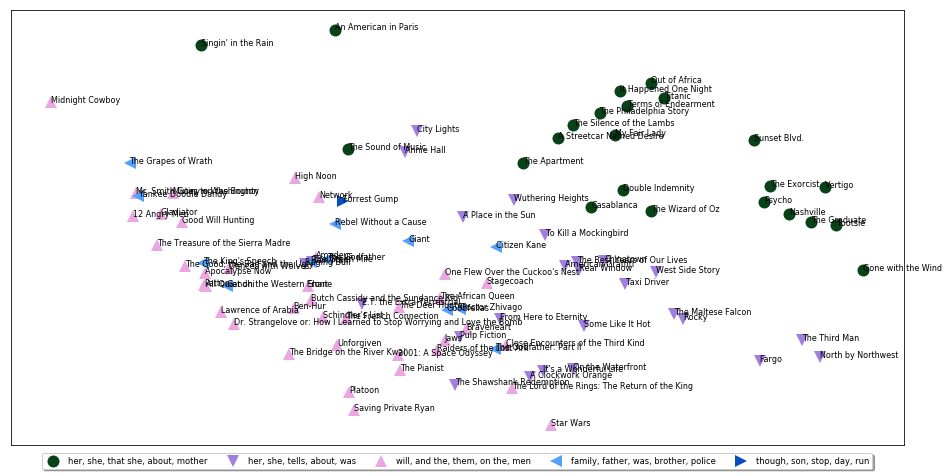

In [52]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8))